In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_file
from utils.plot_utils import plot_targets
from scipy.signal import find_peaks

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

In [2]:
root_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"
sub_ids = [sub_id for sub_id in os.listdir(root_dir) if sub_id.startswith("sub-pp")]
print(sub_ids[-5:])

['sub-pp166', 'sub-pp167', 'sub-pp168', 'sub-pp169', 'sub-pp170']


In [8]:
i_sub_id = sub_ids.index("sub-pp058")
print(f"{i_sub_id:d} > {sub_ids[i_sub_id]:s}")
my_task = "Slow"
my_run = ""

56 > sub-pp058


sub-pp058
['sub-pp058_task-walkSlowSchub_events.tsv', 'sub-pp058_task-walkSlow_events.tsv']


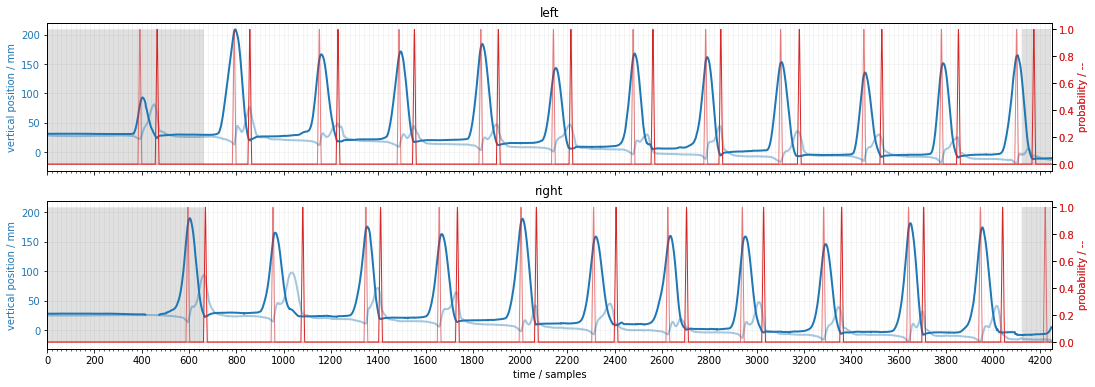

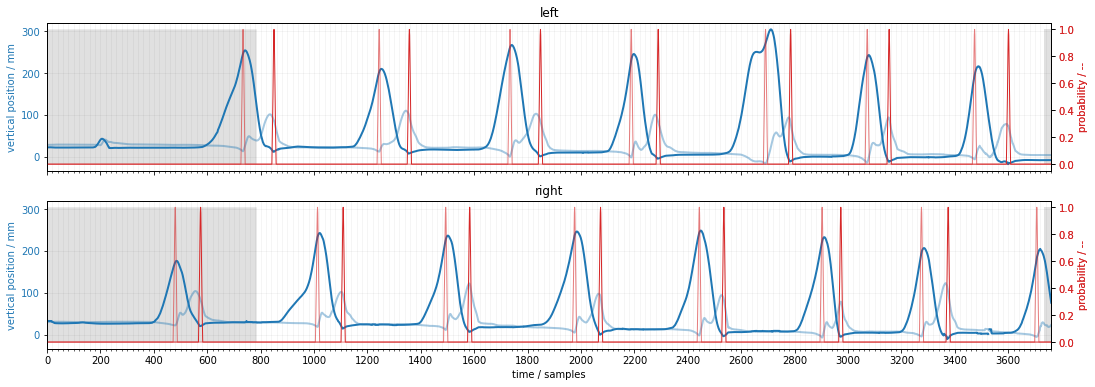

In [9]:
for (_, sub_id) in enumerate(sub_ids[i_sub_id:i_sub_id+1]):
    print(sub_id)
    event_filenames = [fname for fname in os.listdir(os.path.join(root_dir, sub_id, "motion")) if (fname.endswith("_events.tsv")) and ("_task-walk"+my_task in fname)]
    if len(my_run) > 0:
        event_filenames = [fname for fname in event_filenames if my_run in fname]
    print(event_filenames)
    for (_, filename) in enumerate(event_filenames):
        # Load the annotated gait events
        df_events = pd.read_csv(os.path.join(root_dir, sub_id, "motion", filename), sep="\t", header=0)
        ix_start  = df_events[df_events["event_type"]=="start"]["onset"].values[0]
        ix_end    = df_events[df_events["event_type"]=="stop"]["onset"].values[0]

        # Get data and targets
        data, targets = load_file(os.path.join(root_dir, sub_id, "motion", filename), tracked_points=["left_ankle", "right_ankle"], visualize=True)

In [10]:
df_out_events = {"sub_id": [], "filename": [], "event_type": [], "ix_ref": []}
df_out_params = {"sub_id": [], "filename": [], "side": [], "gait_phase": [], "ix_onset": [], "duration": []}

# Loop over the subject ids
for (i_sub_id, sub_id) in enumerate(sub_ids):
    # print(f"{i_sub_id:>4d}: {sub_id:s}")
    
    # Get a list of event filenames (for the walk* trials only)
    event_filenames = [fname for fname in os.listdir(os.path.join(root_dir, sub_id, "motion")) if (fname.endswith("_events.tsv")) and ("_task-walk" in fname)]
    for (i_filename, filename) in enumerate(event_filenames):
        # print(f"{i_filename:>10d}: {filename:s}")
        
        # Load the annotated gait events
        df_events = pd.read_csv(os.path.join(root_dir, sub_id, "motion", filename), sep="\t", header=0)
        ix_start  = df_events[df_events["event_type"]=="start"]["onset"].values[0]
        ix_end    = df_events[df_events["event_type"]=="stop"]["onset"].values[0]
        
        # Load the opto-electronic stereophotogrammetry data
        # df_omc = pd.read_csv(os.path.join(root_dir, sub_id, "motion", filename.replace("_events.tsv", "_tracksys-omc_motion.tsv")), sep="\t", header=0)
        
        # Load the inertial measurement unit data
        # df_imu = pd.read_csv(os.path.join(root_dir, sub_id, "motion", filename.replace("_events.tsv", "_tracksys-imu_motion.tsv")), sep="\t", header=0)
        
        # Get data and targets
        data, targets = load_file(os.path.join(root_dir, sub_id, "motion", filename), tracked_points=["left_ankle", "right_ankle"], visualize=False)
        
        # ---------- Identify initial and final contacts ----------
        indx_ICL, _ = find_peaks(targets["initial_contact_left"][:,0], height=0.5, distance=50)
        indx_FCL, _ = find_peaks(targets["final_contact_left"][:,0], height=0.5, distance=50)
        indx_ICR, _ = find_peaks(targets["initial_contact_right"][:,0], height=0.5, distance=50)
        indx_FCR, _ = find_peaks(targets["final_contact_right"][:,0], height=0.5, distance=50)
        
        # Add to output dictionary
        df_out_events["sub_id"] += [sub_id for _ in range(len(indx_ICL)+len(indx_FCL)+len(indx_ICR)+len(indx_FCR))]
        df_out_events["filename"] += [filename for _ in range(len(indx_ICL)+len(indx_FCL)+len(indx_ICR)+len(indx_FCR))]
        df_out_events["event_type"] += ["ICL" for _ in range(len(indx_ICL))]
        df_out_events["event_type"] += ["FCL" for _ in range(len(indx_FCL))]
        df_out_events["event_type"] += ["ICR" for _ in range(len(indx_ICR))]
        df_out_events["event_type"] += ["FCR" for _ in range(len(indx_FCR))]
        df_out_events["ix_ref"] += indx_ICL.tolist()
        df_out_events["ix_ref"] += indx_FCL.tolist()
        df_out_events["ix_ref"] += indx_ICR.tolist()
        df_out_events["ix_ref"] += indx_FCR.tolist()
        
        # Extract left swings
        # print(f"{'Num of left swings:':>20s} {len(indx_ICL)-1:>2d}")
        for i in range(len(indx_ICL)-1):
            # print(f"{i+1:>4d} {'stride':>8s}: {indx_ICL[i]:>4d} - {indx_ICL[i+1]:>4d}: {indx_ICL[i+1]-indx_ICL[i]:>4d} ({(indx_ICL[i+1]-indx_ICL[i])/200:>.2f})")
            j = np.argwhere((indx_FCL > indx_ICL[i]) & (indx_FCL < indx_ICL[i+1]))[:,0]
            if(len(j)>1):
                print(f"More than 1 final contact detected! Check the data file!")
            elif(len(j)<1):
                print(f"No final contact was detected. Check the data file!")
            else:
                # print(f"{4*' ':s} {'stance':>8s}: {indx_ICL[i]:>4d} - {indx_FCL[j[0]]:>4d}: {indx_FCL[j[0]]-indx_ICL[i]:>4d} ({(indx_FCL[j[0]]-indx_ICL[i])/200:>.2f})")
                # print(f"{4*' ':s} {'swing':>8s}: {indx_FCL[j[0]]:>4d} - {indx_ICL[i+1]:>4d}: {indx_ICL[i+1]-indx_FCL[j[0]]:>4d} ({(indx_ICL[i+1]-indx_FCL[j[0]])/200:>.2f})")
                df_out_params["sub_id"] += [sub_id for _ in range(3)]
                df_out_params["filename"] += [filename for _ in range(3)]
                df_out_params["side"] += ["left" for _ in range(3)]
                df_out_params["gait_phase"] += ["stride", "stance", "swing"]
                df_out_params["ix_onset"] += [indx_ICL[i], indx_ICL[i], indx_FCL[j[0]]]
                df_out_params["duration"] += [indx_ICL[i+1]-indx_ICL[i], indx_FCL[j[0]]-indx_ICL[i], indx_ICL[i+1]-indx_FCL[j[0]]]
            
            
        # Extract right swings
        # print(f"{'Num of right swings:':>20s} {len(indx_ICR)-1:>2d}")
        for i in range(len(indx_ICR)-1):
            # print(f"{i+1:>4d} {'stride':>8s}: {indx_ICR[i]:>4d} - {indx_ICR[i+1]:>4d}: {indx_ICR[i+1]-indx_ICR[i]:>4d} ({(indx_ICR[i+1]-indx_ICR[i])/200:>.2f})")
            j = np.argwhere((indx_FCR > indx_ICR[i]) & (indx_FCR < indx_ICR[i+1]))[:,0]
            if(len(j)>1):
                print(f"More than 1 final contact detected! Check the data file!")
            elif(len(j)<1):
                print(f"No final contact was detected. Check the data file!")
            else:
                # print(f"{4*' ':s} {'stance':>8s}: {indx_ICR[i]:>4d} - {indx_FCR[j[0]]:>4d}: {indx_FCR[j[0]]-indx_ICR[i]:>4d} ({(indx_FCR[j[0]]-indx_ICR[i])/200:>.2f})")
                # print(f"{4*' ':s} {'swing':>8s}: {indx_FCR[j[0]]:>4d} - {indx_ICR[i+1]:>4d}: {indx_ICR[i+1]-indx_FCR[j[0]]:>4d} ({(indx_ICR[i+1]-indx_FCR[j[0]])/200:>.2f})")
                df_out_params["sub_id"] += [sub_id for _ in range(3)]
                df_out_params["filename"] += [filename for _ in range(3)]
                df_out_params["side"] += ["right" for _ in range(3)]
                df_out_params["gait_phase"] += ["stride", "stance", "swing"]
                df_out_params["ix_onset"] += [indx_ICR[i], indx_ICR[i], indx_FCR[j[0]]]
                df_out_params["duration"] += [indx_ICR[i+1]-indx_ICR[i], indx_FCR[j[0]]-indx_ICR[i], indx_ICR[i+1]-indx_FCR[j[0]]]
print("Cell execution completed. You can go home now.")

Cell execution completed. You can go home now.


In [11]:
pd.DataFrame(df_out_params).tail()

,sub_id,filename,side,gait_phase,ix_onset,duration
11383,sub-pp170,sub-pp170_task-walkSlow_events.tsv,right,stance,966,183
11384,sub-pp170,sub-pp170_task-walkSlow_events.tsv,right,swing,1149,85
11385,sub-pp170,sub-pp170_task-walkSlow_events.tsv,right,stride,1234,284
11386,sub-pp170,sub-pp170_task-walkSlow_events.tsv,right,stance,1234,183
11387,sub-pp170,sub-pp170_task-walkSlow_events.tsv,right,swing,1417,101


In [12]:
pd.DataFrame(df_out_params).to_csv("D:\\Desktop\\df_out_params.tsv", sep="\t")

As per definition the gait cycle start with an initial contact and ends with the next initial contact of the same foot.